cuda
Entire classes : ['bad', 'good']
Size of entire dataset : 5178
Size of train dataset : 4142
Size of train dataset : 1036


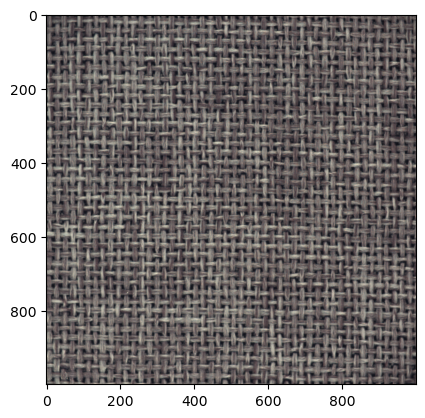

torch.Size([1, 3, 1000, 1000])


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

num_epochs = 10
batch_size = 1
learning_rate = 0.001


# Tensor -1~1 change
transform = transforms.Compose(
    [transforms.Resize((1000,1000)),
    transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

# Data Load
image_dataset = torchvision.datasets.ImageFolder(root="/home/iai/Desktop/Jeewon/Seminar/20230112_MVtecAD/data/simpleclassification_good_bad/dataset", transform = transform)
print(f'Entire classes : {image_dataset.classes}')

train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size

train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])
# print(train_dataset[0][0].size())
# print(test_dataset[0][0].size())
print(f'Size of entire dataset : {len(image_dataset)}')
print(f'Size of train dataset : {len(train_dataset)}')
print(f'Size of train dataset : {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv3 = nn.Conv2d(16,32,5)
        self.pool1 = nn.MaxPool2d(4,4)
        self.pool2 = nn.MaxPool2d(5,5)
        self.fc1 = nn.Linear(32*9*9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = x.view(-1, 32*9*9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)

Epoch [1/10], Step [1000/4142], Loss: 0.4402
Epoch [1/10], Step [2000/4142], Loss: 0.3629
Epoch [1/10], Step [3000/4142], Loss: 0.2080
Epoch [1/10], Step [4000/4142], Loss: 0.1715
Epoch [2/10], Step [1000/4142], Loss: 0.2379
Epoch [2/10], Step [2000/4142], Loss: 0.1795
Epoch [2/10], Step [3000/4142], Loss: 0.2516
Epoch [2/10], Step [4000/4142], Loss: 0.2308
Epoch [3/10], Step [1000/4142], Loss: 0.2344
Epoch [3/10], Step [2000/4142], Loss: 0.1902
Epoch [3/10], Step [3000/4142], Loss: 0.2253
Epoch [3/10], Step [4000/4142], Loss: 0.2990
Epoch [4/10], Step [1000/4142], Loss: 0.2059
Epoch [4/10], Step [2000/4142], Loss: 2.0178
Epoch [4/10], Step [3000/4142], Loss: 0.2375
Epoch [4/10], Step [4000/4142], Loss: 0.2152
Epoch [5/10], Step [1000/4142], Loss: 1.6830
Epoch [5/10], Step [2000/4142], Loss: 0.1821
Epoch [5/10], Step [3000/4142], Loss: 0.1543
Epoch [5/10], Step [4000/4142], Loss: 0.1793
Epoch [6/10], Step [1000/4142], Loss: 1.5543
Epoch [6/10], Step [2000/4142], Loss: 0.2575
Epoch [6/1

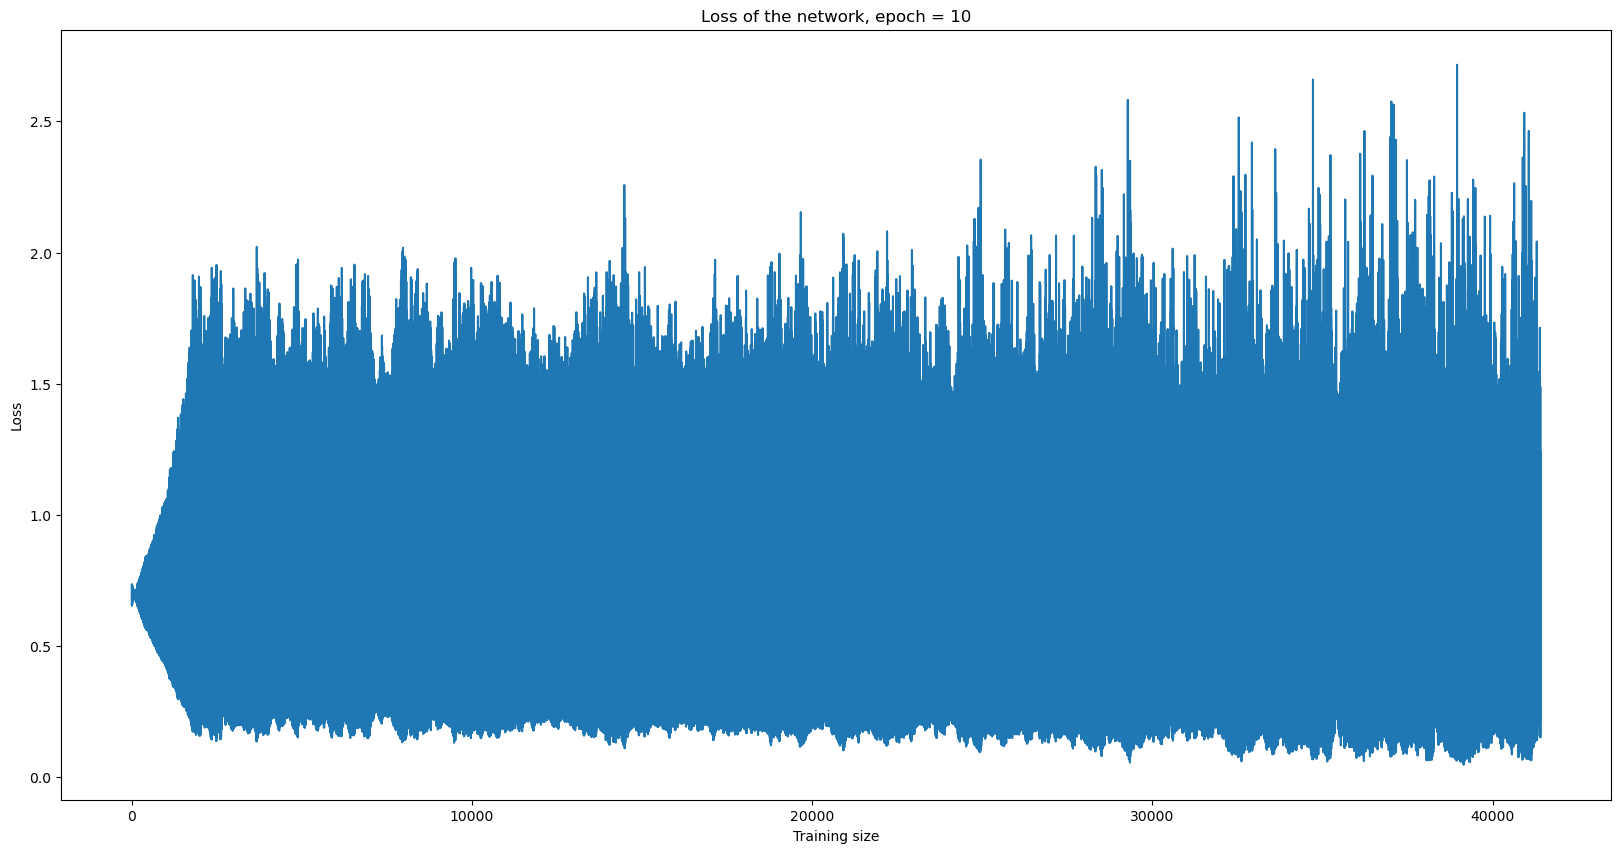

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

loss_list = []
# training phase
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
        if (i+1) %1000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
print("Training done")

plt.figure(figsize=(20,10))
plt.plot(loss_list)
plt.xlabel('Training size')
plt.ylabel('Loss')
plt.title('Loss of the network, epoch = 10')
plt.show()

Accuracy of the network : 77.02702702702703 %


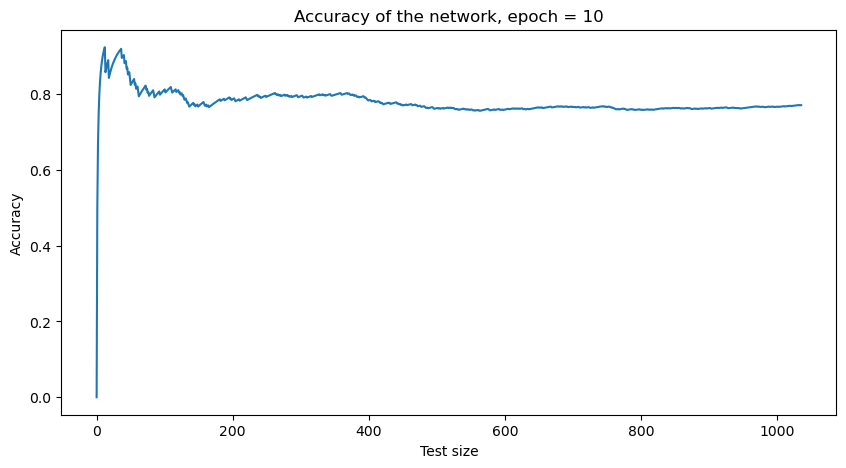

In [4]:
acc_list = []
accuracy = 0.0

# test phase
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
        
        acc_list.append(n_correct/n_samples)
    
    accuracy = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network : {accuracy} %')

plt.figure(figsize=(10,5))
plt.plot(acc_list)
plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.title('Accuracy of the network, epoch = 10')
plt.legend
plt.show()